In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [104]:
df = pd.read_csv('../../data/preprocessed/main-data.csv')

In [105]:
# convert day to numerical
le = LabelEncoder()
df['day'] = le.fit_transform(df['day'])
df.drop(['category_names','packet_date'], axis=1, inplace=True)

df['is_vip'] = df['is_vip'].astype(int)

# Define features and target variable
X = df[df.columns.difference(['collection_duration'])]
y = df['collection_duration']


In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [109]:
# Create Stacking Ensemble Algorithm for Regression Problem
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define hyperparameter distributions for base estimators
param_dist_linear = {}
param_dist_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7, 10, 15, 20],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
}
param_dist_gb = {'n_estimators': [100],
                 'learning_rate': uniform(0.01, 0.2 - 0.01)}
param_dist_en = {'alpha': uniform(0.0001, 0.01 - 0.0001)}
param_dist_xgb = {'n_estimators': randint(50, 200),
                  'max_depth': randint(3, 8),
                  'learning_rate': uniform(0.01, 0.2 - 0.01)}

# Define hyperparameter distribution for final estimator
param_dist_final = {'n_estimators': randint(50, 200),
                    'max_depth': randint(3, 8),
                    'learning_rate': uniform(0.01, 0.2 - 0.01)}

# Base estimators
base_estimators = [
    ('LinearRegression', LinearRegression()),
    ('GradientBoosting', RandomizedSearchCV(GradientBoostingRegressor(random_state=42), param_dist_gb, n_iter=5, cv=3)),
    ('ElasticNet', RandomizedSearchCV(ElasticNet(), param_dist_en, n_iter=5, cv=3)),
    ('XGBoost', RandomizedSearchCV(XGBRegressor(random_state=42), param_dist_xgb, n_iter=5, cv=3)),
    ('RandomForest', RandomizedSearchCV(RandomForestRegressor(random_state=42), param_dist_rf, n_iter=5, cv=3)),
]

# StackingRegressor
stacking_reg = StackingRegressor(
    estimators=base_estimators,
    final_estimator=RandomizedSearchCV(XGBRegressor(random_state=42), param_dist_xgb, n_iter=5, cv=3),
)

# Fit the StackingRegressor
for name, estimator in base_estimators:
    print(f"Fitting {name}...")
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} fitting done.")
    print(f"{name} RMSE: {rmse}")
    print(f"{name} MAE: {mae}")
    print(f"{name} R2: {r2}")
    print("---------------------------------------------------")

# Fit the StackingRegressor
stacking_reg.fit(X_train, y_train)
print("StackingRegressor fitting done.")

try:
    print("Best parameters for final estimator:")
    print(stacking_reg.final_estimator_.best_params_)
except:
    print("No final estimator fitted.")
    pass

# Make predictions
y_pred_stacking = stacking_reg.predict(X_test)

# Evaluate the stacked model
rmse_stacking = root_mean_squared_error(y_test, y_pred_stacking)
mae_stacking = mean_absolute_error(y_test, y_pred_stacking)
r2_stacking = r2_score(y_test, y_pred_stacking)

print("Stacking MAE:", mae_stacking)
print("Stacking R2:", r2_stacking)
print("Stacking RMSE:", rmse_stacking)


Fitting LinearRegression...
LinearRegression fitting done.
LinearRegression RMSE: 2.0234060067436896
LinearRegression MAE: 1.5955589699561994
LinearRegression R2: 0.3382891758460833
---------------------------------------------------
Fitting GradientBoosting...
GradientBoosting fitting done.
GradientBoosting RMSE: 2.017132498069466
GradientBoosting MAE: 1.592041875784082
GradientBoosting R2: 0.3423860433768203
---------------------------------------------------
Fitting ElasticNet...
ElasticNet fitting done.
ElasticNet RMSE: 2.0218870229625474
ElasticNet MAE: 1.5947894352450955
ElasticNet R2: 0.33928230399569526
---------------------------------------------------
Fitting XGBoost...
XGBoost fitting done.
XGBoost RMSE: 2.022565214031991
XGBoost MAE: 1.595804004595357
XGBoost R2: 0.3388389874438883
---------------------------------------------------
Fitting RandomForest...
RandomForest fitting done.
RandomForest RMSE: 2.0191566075491445
RandomForest MAE: 1.5938369673406196
RandomForest R2:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 36), dtype=float32). Expected shape (None, 1, 31), but input has incompatible shape (None, 36)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 36), dtype=float32)
  • training=True
  • mask=None

In [ ]:
p_accuracy = [(1 - np.abs(pred - actual) / actual) * 100 for pred, actual in zip(y_pred_stacking, y_test)]

# Print P_accuracy
print("P_accuracy: Mean: %.2f%%, Min: %.2f%%, Max: %.2f%%" % (np.mean(p_accuracy), np.min(p_accuracy), np.max(p_accuracy)))

P_accuracy: Mean: 69.23%, Min: -60.66%, Max: 100.00%


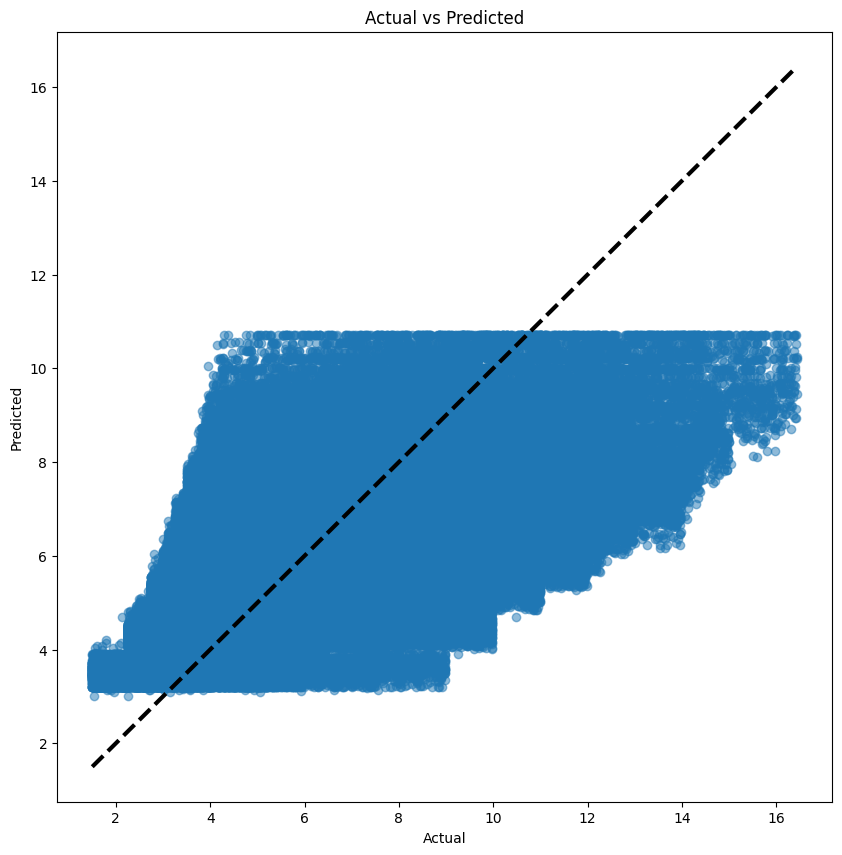

In [ ]:
# predicted vs actual
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred_stacking, alpha=0.5, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, label='Ideal Prediction')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()
